# Floored cliquet options

Let $T$ be a future point in time, and divide the interval $\left[0, T\right]$ into $N$ subintervals, called reset periods, of length $\Delta_n = T_n − T_{n−1}$, where $\{ T_n \}^ N_{n=0}$, $T_0 = 0$, $T_N = T$ are referred to as the reset days. 

The return of an asset with price process $S_t$ over a reset period $\left[T_{n−1}, T_n\right)$ is then defined as

$$R_n = \frac{S_{T_n}}{S_{T_{n-1}}} - 1$$

Additionally the *truncated returns* is defined as:

$$\bar{R_n} = \max \left( \min \left(R_n, C\right), F\right)$$

where $F$ and $C$ are the floor and cap levels respectively (the absence of floor and caps corresponds to $F=-1$ and $C=+\infty$).

The  *truncated returns* is represented by:

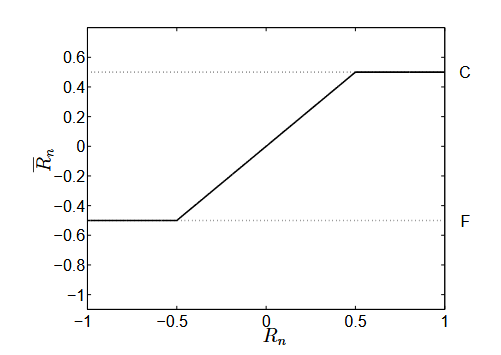


An option with this configuration is called a **Cliquet Option**. A general Cliquet option has a payoff $Y$ at time $T$ of:

$$Y = \min\left( \max \left(\sum_{n=1}^N \bar{R_n}, F_g\right), C_g \right)$$

where $F_g$ and $C_g$ are the global floor and global cap, representing the minimum and maximum returns, respectively.

We can use the **QQuantLib** library for obtaining the payoff of a **Cliquet Option** using various **Quantum Amplitude Estimation** algorithms.

In [ ]:
import sys
sys.path.append("../../")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qat.lang.AQASM as qlm
from copy import deepcopy
%matplotlib inline

In [ ]:
#This cell loads the QLM solver. See notebook: 00_AboutTheNotebooksAndQPUs.ipynb
from QQuantLib.qpu.get_qpu import get_qpu
# myqlm qpus: python, c
# QLM qpus accessed using Qaptiva Access library: qlmass_linalg, qlmass_mps
# QLM qpus: Only in local Quantum Learning Machine: linalg, mps
my_qpus = ["python", "c", "qlmass_linalg", "qlmass_mps", "linalg", "mps"]

linalg_qpu = get_qpu(my_qpus[1])

## 1. Getting the Paths

To evaluate the final payoff of a Cliquet option, the first step is to build the possible paths the asset can follow from one reset day to the next (for all reset days under evaluation). These paths will be constructed using the **Black-Scholes** model.

For each possible reset day, we define a domain discretization of the asset as follows:

* **Initial reset date**: We only need the initial value of the asset.
* **Second reset date**: We compute $N$ possible paths starting from the initial reset day.
* **Third reset date**: We generate $N$ possible paths for each asset value at the second reset day, resulting in $N^2$ possible paths at this point.

For each subsequent reset day, $N$ new paths are generated for each possible value from the preceding reset day. If there are $m$ reset days, then at the final reset day, we will have $N^m$ possible paths.

To implement this scheme, the *bs_tree* function from the **QQuantLib.finance.classical_finance** module is used. The function takes the following inputs:


* s_0: Initial value of the asset
* risk_free_rate: Risk-free required to model the **Black-Scholes** evolution of the asset.
* volatility: Volatility of the asset required to model the **Black-Scholes** evolution.
* times: A list of reset days to evaluate
* discretization: Number of points for domain discretization.
* bounds: Bounds for truncating the probability density.


The *bs_tree* returns two objects:

* s_t: A list containing all possible discretized values of the asset for each reset day (in tree format).
* p_t: A list containing the probabilities of all the distinct paths generated between the initial and final reset days.



In [ ]:
from QQuantLib.finance.classical_finance import bs_tree

In [ ]:
#Initial value for the asset
s_0 = 1.0
risk_free_rate = 0.03
volatility = 0.4
reset_dates = np.array([0.0, 1.0, 2.0])

#Discretization: 2^n_qbits
n_qbits = 5

tree_s, bs_path_prob = bs_tree(
    s_0=s_0,
    risk_free_rate=risk_free_rate, 
    volatility=volatility,
    times=reset_dates,
    discretization= 2**n_qbits,
    bounds = 7
)

The first output of *bs_tree* (stored in the variable *tree_s*) contains the possible values of the asset for each reset day.

* The first element of *tree_s* represents the initial value of the asset.
* The second element contains the possible asset values at the second reset day.
* The third element has the values of the asset at the third reset day for each posible value of the second reset day. So it has $2^{n\_qbits}$ * $2^{n\_qbits}$ values

In [ ]:
# First reset day 
tree_s[0]

In [ ]:
# Second reset day: MUST have 2^n_qbits values
print(len(tree_s[1]))

In [ ]:
# Third reset day: MUST have 2^n_qbits * 2^n_qbits values
print(len(tree_s[2]))

The first $2^n$ values of the third element of the *tree_s* contains the posible asset values corresponding to the first asset value of the second reset day, and so on.

In [ ]:
print("Possible asset values in third reset day: \n{}".format(
    tree_s[2][:2**n_qbits]))
print("for first asset value {} in second reset day: ".format(tree_s[1][0]))

In [ ]:
print("Possible asset values in third reset day: \n{}".format(
    tree_s[2][2**n_qbits: 2*2**n_qbits]))
print("for second asset value {} in second reset day: ".format(tree_s[1][1]))

The *tree_to_paths* function from **QQuantLib.finance.classical_finance** module transforms the *tree_s* variable into a table format, where all the possible paths of the asset are stored for each reset day.


In [ ]:
from QQuantLib.finance.classical_finance import tree_to_paths

In [ ]:
# Posible path of the assets along the three reset days
paths_s = tree_to_paths(tree_s)
pdf = pd.DataFrame(paths_s, index=["reset_day0", "reset_day1", "reset_day2"])

In [ ]:
pdf

In [ ]:
# Possible paths for the asset
for i in range(len(pdf.columns)):
    plt.plot(pdf[i], 'o-')

The variable *bs_path_prob* (the second output of the *bs_tree*) is a list where each element contains the probability of the built paths for each reset day. The last element contains the probability of all the built paths from the initial reset day to the final one.

In [ ]:
bs_path_prob

In [ ]:
# Probabilities for all the built paths from initial to last reset day
plt.plot(bs_path_prob[-1])
plt.xlabel("Paths")
plt.ylabel("Probability")

## 2. Getting the Cliquet Option payoff

For each built path, we need to compute the associated payoff of the Cliquet option. This can be done using the *cliquet_cashflows* function from **QQuantLib.finance.classical_finance**. The inputs are:

* local_cap: $C$
* local_floor: $F$
* global_cap: $C_g$
* global_floor: $F_g$
* paths: The built paths from *tree_to_paths* function

The output is the Cliquet payoff for each possible path from the initial reset day to the final one.


In [ ]:
from QQuantLib.finance.classical_finance import cliquet_cashflows

In [ ]:
local_cap = 0.1
local_floor = -0.1
global_cap = 0.2
global_floor = -0.2

In [ ]:
cliqet_payoffs = cliquet_cashflows(
    local_cap = local_cap,
    local_floor = local_floor,
    global_cap = global_cap,
    global_floor = global_floor,
    paths=paths_s
)

In [ ]:
# Cliquet Pay Off for each built path
plt.plot(cliqet_payoffs)
plt.xlabel("Paths")
plt.ylabel("Cliquet PayOffs")

## 3. The return of the Cliquet option


Now, we can compute the return of the Cliquet option by calculating the expected value of the probability of all the paths and their corresponding payoff.

In [ ]:
cliquet_return = np.dot(bs_path_prob[-1], cliqet_payoffs)

print("Expected return of the cliquet at the last reset day: {}".format(
    cliquet_return
))

We need to discount the risk-free rate, as usual, to determine the return at the initial day.

In [ ]:
final_return = np.exp(-risk_free_rate * reset_dates[-1]) * cliquet_return

print("Final Return: {}".format(final_return))

## 4. Cliquet Option using *q_solve_integral*

The *Cliquet* option return can be computed easily using the *q_solve_integral* function from **QQuantLib.finance.quantum_integration** (see *misc/notebooks/10_ApplicationTo_Finance_01_IntegralComputing.ipynb*).

We only need to provide the probability and payoff arrays and properly configure the **AE** algorithm.

In [ ]:
from QQuantLib.finance.quantum_integration import q_solve_integral

In [ ]:
#probability definition
p_x = bs_path_prob[-1]
#probability normalisation
p_x_normalisation = np.sum(p_x)
norm_p_x = p_x / p_x_normalisation

#Function definition
f_x = cliqet_payoffs
f_x_normalisation = np.max(np.abs(f_x))
norm_f_x = f_x / f_x_normalisation

In [ ]:
ae_dict = {
    #QPU
    'qpu': linalg_qpu,
    #Multi controlled decomposition
    'mcz_qlm': False, 
    
    #shots
    'shots': None,
    
    #MLAE
    'schedule': None,
    'delta' : None,
    'ns' : None,
    
    #CQPEAE
    'auxiliar_qbits_number': None,
    "window" : None,  
    "kaiser_alpha" : None,
    #IQPEAE
    'cbits_number': None,
    #IQAE & RQAQE
    'epsilon': None,
    #IQAE
    'alpha': None,
    #RQAE
    'gamma': None,
    'q': None,
    #For encoding class
    "multiplexor": True
}

In [ ]:
ae_dict.update({
    "array_function":norm_f_x,
    "array_probability": norm_p_x,
})

# PayOff can be positive and negative so better use encoding 2
ae_dict.update({"encoding" : 2})

### 4.1 IQAE

In [ ]:
ae_dict.update({
    "ae_type" : "IQAE",
    "epsilon" : 0.01,
    "alpha" : 0.05,
    "shots" : 100
})

In [ ]:
%%time
iqae_solution, iqae_object = q_solve_integral(**ae_dict)

In [ ]:
iqae_cliquet_return = iqae_solution * f_x_normalisation * p_x_normalisation

In [ ]:
print("Cliquet Return computed using IQAE: {}".format(iqae_cliquet_return["ae"].iloc[0]))
print("True Cliquet return: {}".format(cliquet_return))

As can be seen, **IQAE** algorithm only returns positive values, so it can not be use for this *Cliquet option* configuration

### 4.2 RQAE

In [ ]:
%%time
ae_dict.update({
    "ae_type" : "RQAE",
    "epsilon" : 0.01,
    "gamma" : 0.05,
    "q" : 1.2
})
rqae_solution, rqae_object = q_solve_integral(**ae_dict)

In [ ]:
q_cliquet_return = rqae_solution * f_x_normalisation * p_x_normalisation

In [ ]:
q_cliquet_return

In [ ]:
(cliquet_return < q_cliquet_return["ae_u"]) & (cliquet_return > q_cliquet_return["ae_l"])

**RQAE** algorithm can return both positive and negative values, so it can be used for this *Cliquet option* configuration.

## 5. ae_cliquet_estimation

The *ae_cliquet_estimation* function allows the user to compute a Cliquet option by configuring an input dictionary:


In [ ]:
from QQuantLib.finance.cliquet_return_estimation import ae_cliquet_estimation

In [ ]:
#Base AE configuration dictionary
ae_dict = {
    #QPU
    'qpu': linalg_qpu,
    #Multi controlled decomposition
    'mcz_qlm': False, 
    
    #shots
    'shots': None,
    
    #MLAE
    'schedule': None,
    'delta' : None,
    'ns' : None,
    
    #CQPEAE
    'auxiliar_qbits_number': None,
    "window" : None,  
    "kaiser_alpha" : None,
    #IQPEAE
    'cbits_number': None,
    #IQAE & RQAQE
    'epsilon': None,
    #IQAE
    'alpha': None,
    #RQAE
    'gamma': None,
    'q': None,
    #For encoding class
    "multiplexor": True
}

In [ ]:
# Asset configuration
asset_config = {
    "n_qbits" : n_qbits,
    "s_0": s_0,
    "risk_free_rate" : risk_free_rate,
    "volatility" : volatility,
    "reset_dates" : [0.0, 1.0, 2.0],
    "bounds": 7
}

#Cliquet option configuration
option_config = {
    "local_cap" : local_cap,
    "local_floor" : local_floor,
    "global_cap" : global_cap,
    "global_floor": global_floor
}

other_configuration = {
    'qpu': linalg_qpu,
    "save": False,
    "file_name": "./ae_problem.csv",
    "number_of_tests": 1
}

ae_dict.update(asset_config)
ae_dict.update(option_config)
ae_dict.update(other_configuration)
ae_dict.update({"encoding" : 2})

In [ ]:
ae_dict.update({
    "ae_type" : "IQAE",
    "epsilon" : 0.01,
    "alpha" : 0.05,
    "shots" : 100
})

In [ ]:
pdf = ae_cliquet_estimation(**ae_dict)

The output of the *ae_cliquet_estimation* function is a pandas DataFrame containing various information, including:

* Asset configuration
* AE algorithm configuration
* Normalization of payoff and probability
* AE estimation of the integral (including Riemman integral and absolute error)
* Financial results (including the discount of the risk-free rate)

In [ ]:
# Asset configuration
pdf[[
    "n_qbits", "s_0", "risk_free_rate", "volatility","bounds",
    "reset_dates", "local_cap", "local_floor", "global_cap", "global_floor"
]]

In [ ]:
# AE algorithm configuration
pdf[[
    'ae_type','schedule', 'delta', 'ns', 
    'auxiliar_qbits_number', 'cbits_number',
    'epsilon', 'alpha', 'gamma', 'q', 'shots',
    'mcz_qlm', 'encoding','multiplexor',
]]

In [ ]:
# Normalisation of payoff and probability
pdf[['payoff_normalisation', 'p_x_normalisation']]

In [ ]:
# AE estimation of the integral Including Riemman expectations and absolute error
pdf[[
    "ae_l_expectation", "ae_expectation", 
    "ae_u_expectation", "riemann_expectation", "absolute_error", "measured_epsilon"
]]

In [ ]:
# Financial results (including the discount of the risk-free rate)
pdf[['finance_exact_price', 'finance_riemann_price', 
     'finance_price_estimation', 'finance_error_riemann', 'finance_error_exact'
]]

In [ ]:
ae_dict.update({
    "ae_type" : "RQAE",
    "epsilon" : 0.001,
    "gamma" : 0.05,
    "q" : 1.2
})
pdf = ae_cliquet_estimation(**ae_dict)

In [ ]:
pdf[[
    "ae_l_expectation", "ae_expectation", 
    "ae_u_expectation", "riemann_expectation", "absolute_error"
]]

In [ ]:
pdf["riemann_expectation"] > pdf["ae_l_expectation"]

In [ ]:
pdf["riemann_expectation"] < pdf["ae_u_expectation"]

## 6. cliquet_return_estimation_step_payoff 


Cliquet options can have both positive and negative returns, so only **RQAE-like** algorithm can provide the correct estimation if the sign is unknown. Other **AE** algorithms can also be used for providing the correct estimation, but the following workaround should be applied:

* The payoff should be split into two parts: a positive and a negative part.
* The *q_solve_integral function* should be executed over both parts.
* The results should be post-processed to return the correct evaluation.

This can be done straightforwardly using the *ae_cliquet_estimation_step_payoff* function.


In [ ]:
from QQuantLib.finance.cliquet_return_estimation_step_payoff import ae_cliquet_estimation_step_po

In [ ]:
ae_dict.update({"encoding" : 0})
ae_dict.update({
    "ae_type" : "IQAE",
    "epsilon" : 0.01,
    "alpha" : 0.05,
    "shots" : 100
})

pdf_parts = ae_cliquet_estimation_step_po(**ae_dict)

In [ ]:
pdf_parts[[
    "ae_expectation", 
    "riemann_expectation", "absolute_error", "measured_epsilon"
]]

In [ ]:
ae_dict.update({
    "ae_type" : "BAYESQAE",
})

In [ ]:
pdf_parts = ae_cliquet_estimation_step_po(**ae_dict)

With this workaround, the typical **AE** algorithms return the correct estimation!

## 7. Command Line Utilities

Inside the **benchmark/q_ae_cliquet/** folder, the following scripts allow the user to compute the return of a *Cliquet option* from the command line using an AE algorithm:

* benchmark_cliquet.py
* benchmark_cliquet_step_po.py (in this case, the splitting payoff workaround is used)

To get a list of the arguments, the following commands should be used:

* python benchmark_cliquet.py -h
* python benchmark_cliquet_step_po.py -h

The output is (for both commands):

    usage: benchmark_cliquet.py [-h] [--count] [--print] [--all] [--exe] [--save] [-folder FOLDER_PATH] [-name FILE_NAME] [-id ID] [-repetitions REPETITIONS]
                                [-json_asset JSON_ASSET] [-json_cliquet JSON_CLIQUET] [-json_ae JSON_AE] [-json_qpu JSON_QPU]

    optional arguments:
      -h, --help            show this help message and exit
      --count               For counting elements on the list
      --print               For printing
      --all                 For executing complete list
      --exe                 For executing program
      --save                For saving results
      -folder FOLDER_PATH   Path for storing folder
      -name FILE_NAME       Name for storing csv. Only applies for --all
      -id ID                For executing only one element of the list
      -repetitions REPETITIONS
                            Number of repetitions the integral will be computed.Default: 1
      -json_asset JSON_ASSET
                            JSON with the asset configuration
      -json_cliquet JSON_CLIQUET
                            JSON with the payoff configuration
      -json_ae JSON_AE      JSON AE algorithm configuration
      -json_qpu JSON_QPU    JSON with the qpu configuration
      


The complete configuration for the computations should be provided using *JSON* files:

#### -json_asset JSON_ASSET

Here, the asset configuration is provided using a JSON file. The *asset_configuration.json* presents an example of a valid asset configuration for a *Cliquet Option*.

#### -json_cliquet JSON_CLIQUET

Here, the configuration of the *Cliquet Option* is provided as a JSON file (this includes the different caps and floors of the option). The *cliquet_configuration.json* presents an example of a valid Cliquet option configuration.

#### -json_ae JSON_AE

Here, the configuration of the *AE* algorithm to use is provided as a JSON file. The *miqae_configuration.json* and *mrqae_configuration.json* present examples of valid AE configurations.

#### -json_qpu JSON_QPU

Here, the configuration of the QPU is provided as a JSON file. The *qpu_ideal.json* presents an example of a QPU configuration file. Noisy simulation can be used by properly modifying the JSON file.

### 7.1 Getting the number of cases to execute.

Providing to the command line execution the argument **--count**, the scripts will return the total number of executions it should be done for complete execution of the configured problem using the different **JSON** files.

So for example:

    python benchmark_cliquet_step_po.py -json_asset asset_configuration.json -json_cliquet cliquet_configuration.json  -json_ae miqae_configuration.json  -json_qpu qpu_ideal.json --count

should provide: 8


### 7.2 Print the info for the case

The **--print** argument allows the user to print the configuration of the problem to solve. It can be used with two additional commands:

* --all: In this case, the complete list of dictionaries is printed.
* -id 5: In this case, the complete configuration of the 5th price estimation problem (with the corresponding **AE** algorithm configuration) will be printed. 


### 7.5 Execution of the case

For executing a selected case the **--exe** argument should be provided in combination with the element of the list of dictionaries to be executed. 

The following command will execute the number 3 estimation Cliquet problem.

    python benchmark_cliquet_step_po.py -json_asset asset_configuration.json -json_cliquet cliquet_configuration.json  -json_ae miqae_configuration.json  -json_qpu qpu_ideal.json -id 3 --print --exe

### 7.6 Other arguments

Other arguments that can be provided are:

* -repetitions REPETITIONS: for executing one case REPETITIONS times
* -folder: Path with folder where the Pandas DataFrames will be saved
* -name: for providing an additional name to the saved pdf
* --save: For saving the obtained Pandas DataFrame

## 8. Results


Here, we provide the performance results of different **AE** algorithms for a Cliquet option. These results were obtained by executing the *benchmark_cliquet_step_po.py* and *benchmark_cliquet.py* scripts from the command line and providing properly configured JSON files.

### Asset Configuration

The asset configuration for the *Cliquet Option* is presented in the following table:

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>         </tr>    <tr>      <th>n_qbits</th>      <th>s_0</th>      <th>risk_free_rate</th>      <th>volatility</th>      <th>bounds</th>      <th>reset_dates</th>      </tr>  </thead>  <tbody>    <tr>      <th>6</th>      <th>1</th>      <th>0.05</th>      <th>0.5</th>      <th>7.0</th>      <th>[0.0, 1.0, 2.0]</th>      </tr>  </tbody></table>

### Cliquet Option Configuration

The configuration of the *Cliquet option* is presented in the following table:

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>        </tr>    <tr>      <th>reset_dates</th>      <th>local_cap</th>      <th>local_floor</th>      <th>global_cap</th>      <th>global_floor</th>     </tr>  </thead>  <tbody>    <tr>      <th>[0.0, 1.0, 2.0]</th>      <th>0.1</th>      <th>-0.1</th>      <th>0.2</th>      <th>-0.2</th>       </tr>  </tbody></table>


### AE algorithms

We have used the 2 following **AE** algorithm configurations:

* **mRQAE**:
    *  $\epsilon = 10^{-2},  10^{-3},  10^{-4},  10^{-5}$
    * $q$: 2
    * $\gamma$: 0.05
    * Encoding Pay Off: Direct.
    * Script used: *benchmark_cliquet.py*
    * QPU: c or LinAlg
* **mIQAE**:
    * $\epsilon = 10^{-2},  10^{-3},  10^{-4},  10^{-5}$
    * $\alpha$: 0.05
    * Encoding Pay Off: Direct and Square.
    * Script used: *benchmark_cliquet_step_po.py*
    * QPU: c or LinAlg    
    

The return of the configured *Cliquet Option* for the asset configuration, calculated using the Riemann integral, is **-0.021686**. Meanwhile, the discounted value is **-0.019622**.

The performance comparison is presented in the following figure, where the *Number of Oracle Calls* is plotted against the *Absolute Error* (in this case, the error is computed relative to the pure Riemann integral value: **-0.021686**):

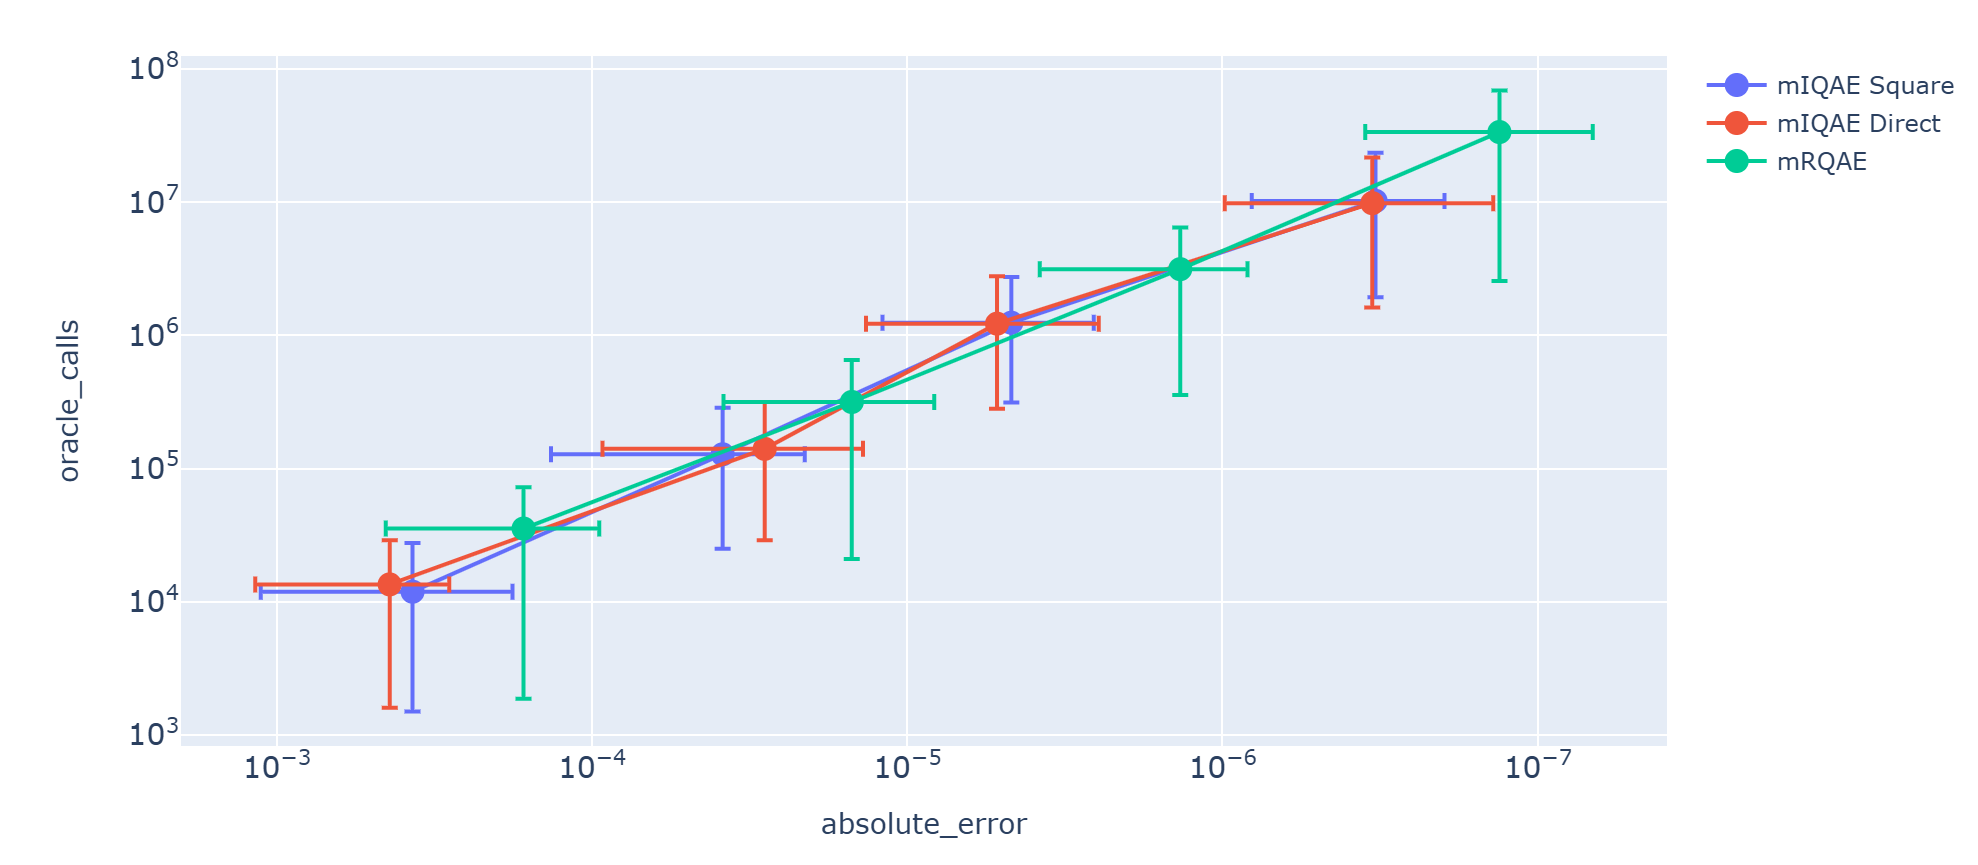



As can be seen, the performance of *mRQAE* is comparable to that of *mIQAE* for both types of payoff encodings (direct and square).
